In [17]:
from pathlib import Path
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from config import TECHNOLOGY_COLORS
from scenarios import (
    generate_scenario_attitudes,
    MODES_2020,
    ATTITUDE_SCENARIOS,
    update_price_w_new_CT,
    CT,
)
import seaborn as sns
import warnings
from figures import sciencify_plotly_fig
warnings.filterwarnings("ignore")
from data.canada import end_use_prices
from functools import partial



def apply_carbon_tax_modification(carbon_tax_mod):
    if carbon_tax_mod != 1:
        new_CT = CT * 2
        update_prices = partial(update_price_w_new_CT, new_CT=new_CT)
        end_use_prices["Price (ct/kWh)"] = end_use_prices[
            ["Year", "Price (ct/kWh)", "Type of fuel", "GEO"]
        ].apply(update_prices, axis=1)
        end_use_prices.to_csv(
            "data/canada/residential_GNZ_end-use-prices-2023_ct_per_kWh.csv",
            index=False,
        )

In [12]:
# based on the parameter fit results - 27.08.24
start_atts = {
    "Electric furnace": 0.283833,
    "Gas furnace": 0.653435,
    "Heat pump": 0.050000,
    "Oil furnace": 0.728319,
    "Biomass furnace": 0.514116,
}

In [15]:
DEFAULT_MODES_AND_YEARS = {
    "Electric furnace": {"end_att": 0.45, "at_year": 2030}, 
    "Gas furnace": {"end_att": 0.45, "at_year": 2030},
    "Heat pump": {"end_att": 0.25, "at_year": 2030},
    "Oil furnace": {"end_att": 0.728319, "at_year": 2030},
    "Biomass furnace": {"end_att": 0.514116, "at_year": 2030},
}
PLUS_TRANSITION_MODES_AND_YEARS = {
    "Electric furnace": {"end_att": 0.383833, "at_year": 2030},
    "Gas furnace": {"end_att": 0.45, "at_year": 2030},
    "Heat pump": {"end_att": 0.35, "at_year": 2030},
    "Oil furnace": {"end_att": 0.728319, "at_year": 2030},
    "Biomass furnace": {"end_att": 0.514116, "at_year": 2030},
}

In [23]:
attitude_mode_fig = sciencify_plotly_fig(
    px.line(
        generate_scenario_attitudes(start_atts, DEFAULT_MODES_AND_YEARS),
        width=500,
        height=400,
        template="plotly_white",
        color_discrete_map=TECHNOLOGY_COLORS,
    )
)
attitude_mode_fig.update_layout(
    yaxis_title="Mode of attitude<br>distribution (-)",
    xaxis_title="Year",
    legend_title="Technology",
    yaxis_range=[0, 0.7],
)

attitude_mode_fig.add_traces(
    [
        go.Scatter(
            x=[2020, 2030, 2050],
            y=[0.05, 0.35, 0.35],
            mode="lines",
            name="+",
            line_dash="dash",
            line_color=TECHNOLOGY_COLORS["Heat pump"],
        ),
        go.Scatter(
            x=[2020, 2030, 2050],
            y=[0.28, 0.38, 0.38],
            mode="lines",
            name="+",
            line_dash="dash",
            line_color=TECHNOLOGY_COLORS["Electric furnace"],
        ),
    ]
)
attitude_mode_fig.write_image("attitude_mode_fig.svg")

In [ ]:
from batch import BatchResult
from itertools import product
from joblib import Parallel, delayed

parameters = {
    "N": [100],
    "province": ["Ontario"],
    "random_seed": range(20, 32),
    "start_year": 2020,
    "n_segregation_steps": [40],
    "interact": [False],
    "price_weight_mode": [0.65],
    "ts_step_length": ["W"],
    "years_per_step": [1],
    "peer_effect_weight": [0.2],
    "hp_subsidy": [0.0],
}


def run_batch(hp_mode, gb_mode):
    DEFAULT_MODES_AND_YEARS["Heat pump"]["end_att"] = hp_mode
    DEFAULT_MODES_AND_YEARS["Gas furnace"]["end_att"] = gb_mode
    parameters["tech_att_mode_table"] = [
        generate_scenario_attitudes(start_atts, DEFAULT_MODES_AND_YEARS)
    ]
    result = BatchResult.from_parameters(parameters, max_steps=30)
    print("ran with", hp_mode, gb_mode)
    return result


for carbon_tax_mod in [1, 2]:
    apply_carbon_tax_modification(carbon_tax_mod)
    for hp_subs in [0.0, 0.3, 0.5]:
        parameters["hp_subsidy"] = [hp_subs]
        results = Parallel(n_jobs=2)(
            delayed(run_batch)(hp_mode, gb_mode)
            for hp_mode, gb_mode in product([0.05, 0.25, 0.35], [0.65, 0.55, 0.45])
        )
        results_dict = dict(
            zip(product([0.05, 0.25, 0.35], [0.65, 0.55, 0.45]), results)
        )
        tech_share_dfs = []
        for key, result in results_dict.items():
            _result_df = result.tech_shares_df
            _result_df["hp mode"] = key[0]
            _result_df["gb mode"] = key[1]
            tech_share_dfs.append(_result_df)

        all_results_df = pd.concat(tech_share_dfs).melt(
            id_vars=["RunId", "province", "year", "hp mode", "gb mode"]
        )

        g = sns.relplot(
            data=all_results_df,
            x="year",
            y="value",
            hue="variable",
            col="gb mode",
            row="hp mode",
            kind="line",
            palette=TECHNOLOGY_COLORS,
            height=2,
        )
        g.set_titles(row_template="hp: {row_name}", col_template="gb: {col_name}")
        all_results_df.to_csv(
            f"results/attitude_sensitivity/CT{carbon_tax_mod}_{hp_subs:.2f}.csv"
        )
        g.figure.savefig(
            f"results/attitude_sensitivity/CT{carbon_tax_mod}_{hp_subs:.2f}.svg"
        )

In [ ]:
lcoh_df = pd.DataFrame.from_records(results[0].results_df["LCOH"])
lcoh_df[["RunId", "AgentID", "Year"]] = results[0].results_df[
    ["RunId", "AgentID", "year"]
]

lcoh_df = (
    lcoh_df.groupby(["Year"])
    .mean()
    .reset_index()
    .drop(["RunId", "AgentID"], axis=1)
    .set_index("Year")
)
px.line(lcoh_df, template="plotly_white")

In [1]:
import pandas as pd
import seaborn as sns
from pathlib import Path
from config import TECHNOLOGY_COLORS

files = list(Path("results/attitude_sensitivity/").glob("CT*.csv"))
dfs = []
for f in files:
    df = pd.read_csv(f, index_col=0)
    ct = int(f.stem[2])
    hp_subs = float(f.stem.split("_")[-1])
    df["ct"] = ct
    df["hp_subs"] = hp_subs
    dfs.append(df)

att_sens_df = pd.concat(dfs)
att_sens_df

,RunId,province,year,hp mode,gb mode,variable,value,ct,hp_subs
0,4,Ontario,2020,0.05,0.65,Gas furnace,0.71,1,0.0
1,4,Ontario,2021,0.05,0.65,Gas furnace,0.72,1,0.0
2,4,Ontario,2022,0.05,0.65,Gas furnace,0.71,1,0.0
3,4,Ontario,2023,0.05,0.65,Gas furnace,0.72,1,0.0
4,4,Ontario,2024,0.05,0.65,Gas furnace,0.71,1,0.0
...,...,...,...,...,...,...,...,...,...
6970,2,Ontario,2046,0.35,0.45,Heat pump,0.67,2,0.5
6971,2,Ontario,2047,0.35,0.45,Heat pump,0.69,2,0.5
6972,2,Ontario,2048,0.35,0.45,Heat pump,0.73,2,0.5
6973,2,Ontario,2049,0.35,0.45,Heat pump,0.76,2,0.5


1 0.0
1 0.3
1 0.5
2 0.0
2 0.3
2 0.5


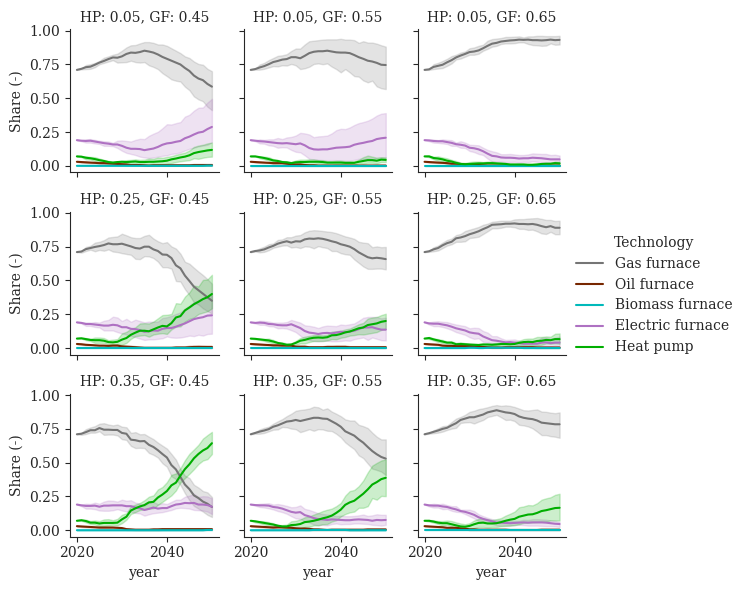

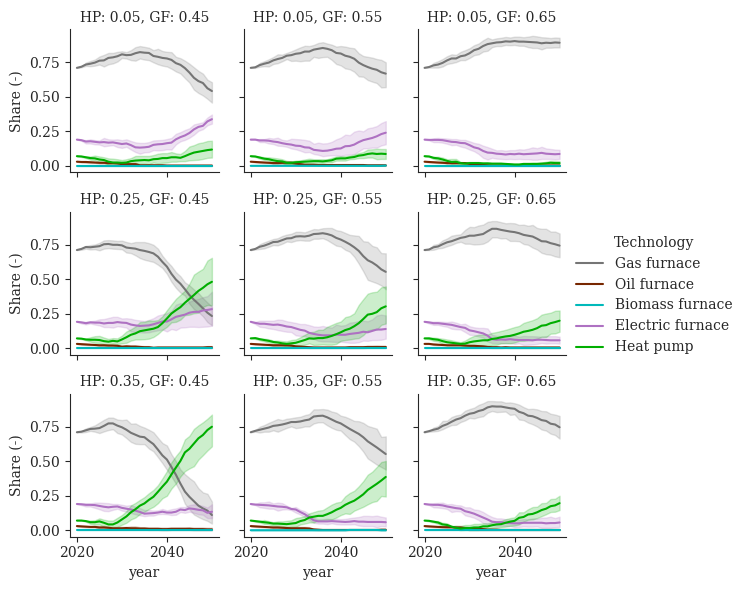

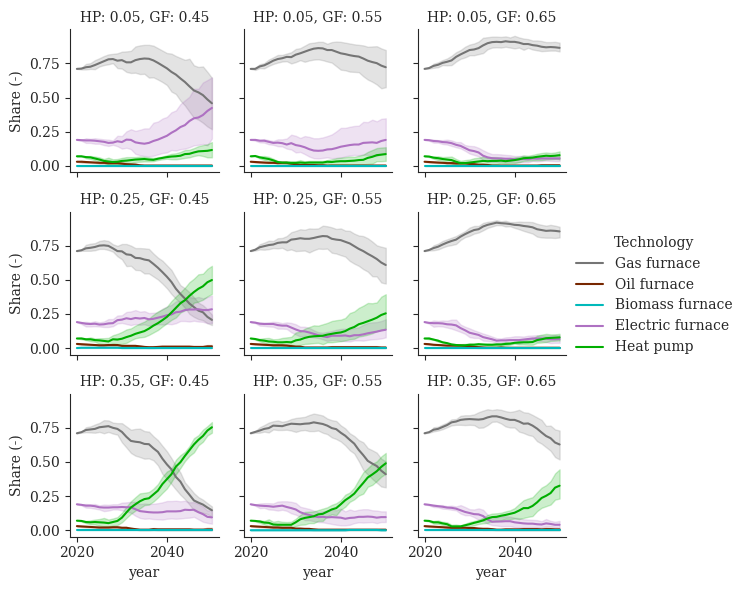

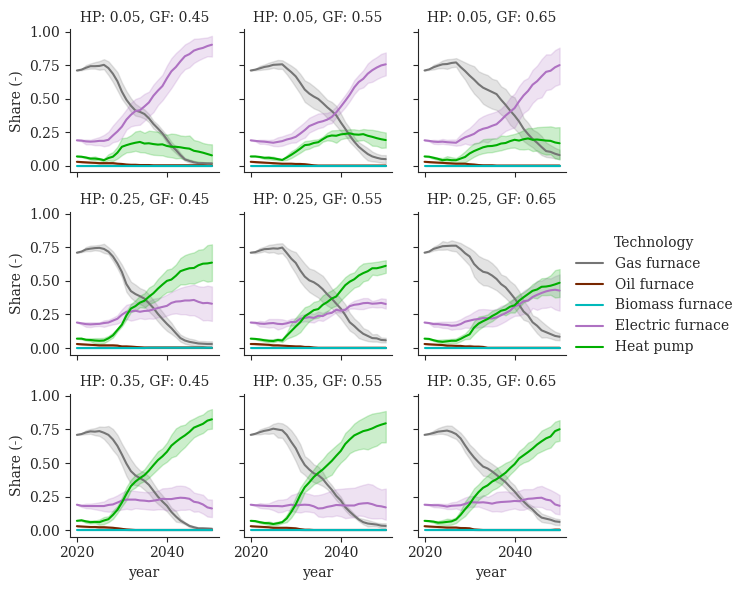

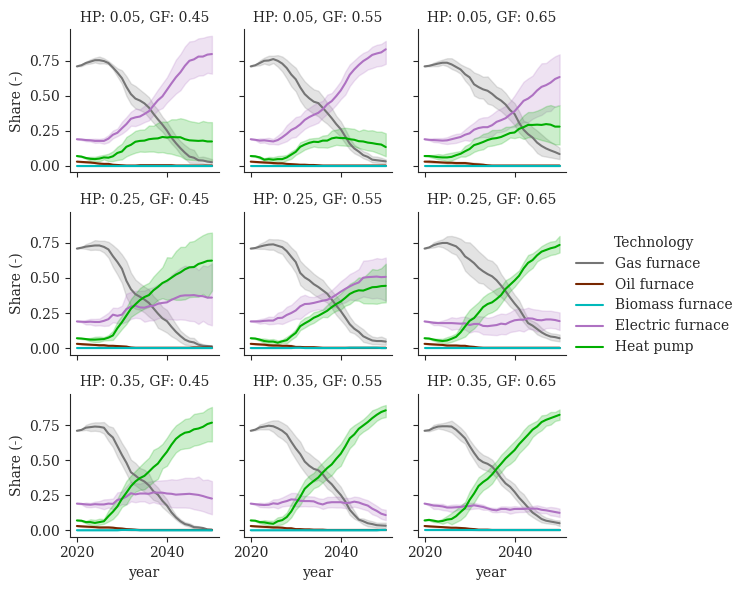

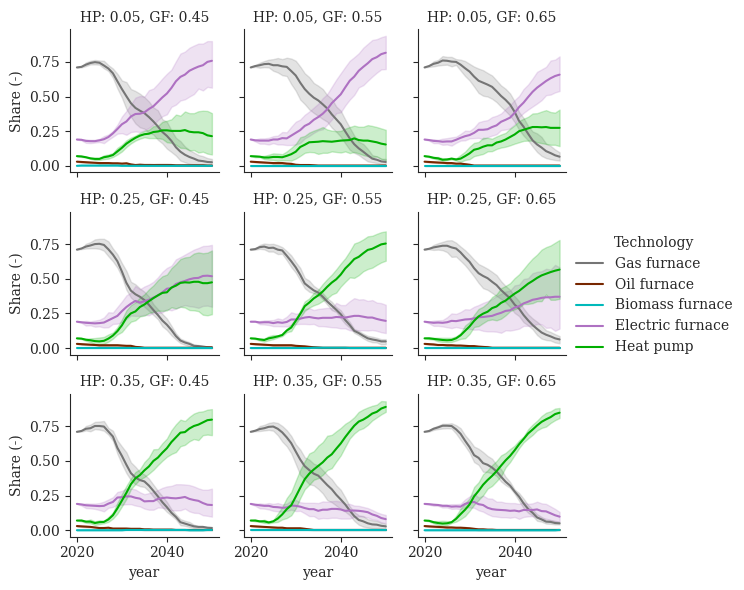

In [11]:
for (ct, hp_subs), df in att_sens_df.groupby(["ct", "hp_subs"]):
    print(ct, hp_subs)
    g = sns.relplot(
        data=df,
        x="year",
        y="value",
        hue="variable",
        col="gb mode",
        row="hp mode",
        kind="line",
        palette=TECHNOLOGY_COLORS,
        height=2,
    )
    g.set_titles(template="HP: {row_name}, GF: {col_name}")
    g.legend.set_title("Technology")
    g.set_ylabels("Share (-)")
    g.figure.savefig(
            f"results/attitude_sensitivity/CT{ct}_{hp_subs:.2f}.svg"
        )

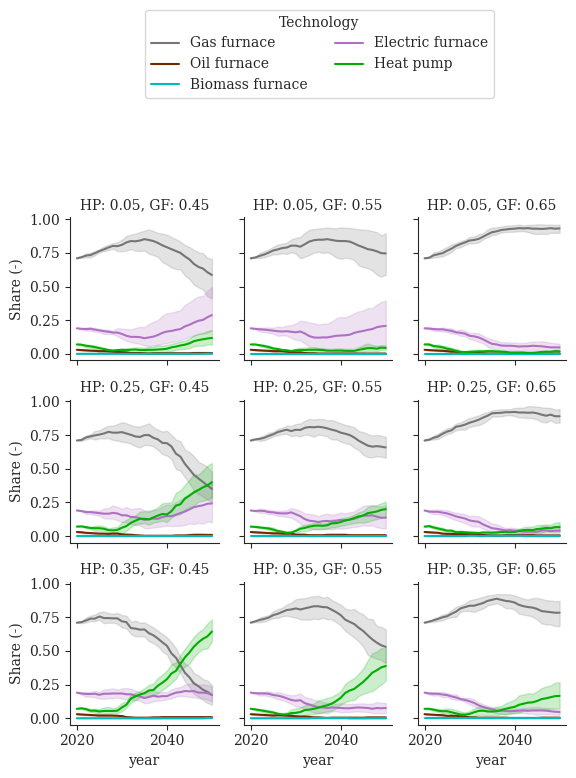

In [6]:
sns.set_style(
    "white",
    rc={
        "xtick.bottom": True,
        "ytick.left": True,
        "text.usetex": True,
        "font.family": "serif", 
        "serif":"Computer Modern Typewriter",
        "font.size": 18,
    },
)
# create figure for the sensitivity in the abm section
sub_att_df = att_sens_df.query("ct==1 & hp_subs==0.0")
# with sns.plotting_context(font_scale=1.05):
# sns.set(font_scale=1.1)
g = sns.relplot(
    sub_att_df,
    x="year",
    y="value",
    hue="variable",
    col="gb mode",
    row="hp mode",
    kind="line",
    palette=TECHNOLOGY_COLORS,
    height=2,
)

g.set_titles(template="HP: {row_name}, GF: {col_name}")
sns.move_legend(
    g, "upper center", bbox_to_anchor=(0.45, 1.3), ncol=2, 
)  
g.legend.set(frame_on=True)
g.set(xticks=[2020, 2040])
g.legend.set_title("Technology")
g.set_ylabels("Share (-)")


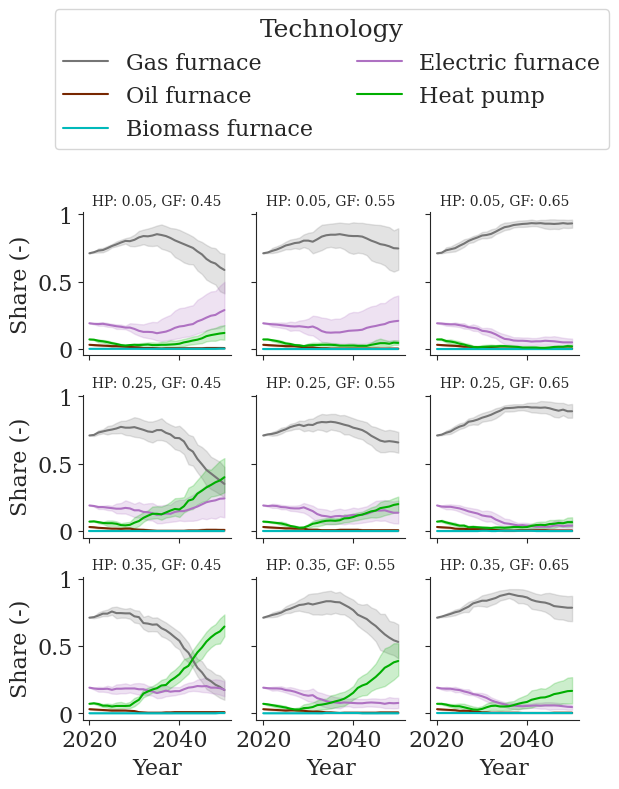

In [9]:
g.legend.set(frame_on=True)
sns.move_legend(
    g, "upper center", bbox_to_anchor=(0.45, 1.3), ncol=2, title_fontsize=18, fontsize=16
)  
g.set_ylabels(
    "Share (-)",
)  # fontsize=18)
g.set_xlabels("Year", fontsize=16)
g.set_ylabels("Share (-)", fontsize=16)
g.set_xticklabels([2020, 2040], fontsize=16)
g.set(yticks=[0,0.5,1],)
g.set_yticklabels([0,0.5,1], fontsize=16)
# g.set_yticks([0,0.3,0.66,1], fontsize=16)

g.figure.savefig("att_sens.svg", bbox_inches="tight")
g.figure.savefig("att_sens.png", bbox_inches="tight")
g.figure

## these are the attitude scenarios for which we calculate sensitivities

In [ ]:
from data.canada import nrcan_tech_shares_df

tech_share_as_att = nrcan_tech_shares_df.loc[2020, "Ontario"] / 100
tech_share_as_att

In [ ]:
SHARE_TRANSITION_MODES_AND_YEARS = {
    "Electric furnace": {
        "end_att": tech_share_as_att["Electric furnace"],
        "at_year": 2021,
    },
    "Gas furnace": {"end_att": tech_share_as_att["Gas furnace"], "at_year": 2021},
    "Heat pump": {"end_att": tech_share_as_att["Heat pump"], "at_year": 2021},
    "Oil furnace": {"end_att": tech_share_as_att["Oil furnace"], "at_year": 2021},
    "Wood or wood pellets furnace": {
        "end_att": tech_share_as_att["Wood or wood pellets furnace"],
        "at_year": 2021,
    },
}

ATTITUDE_SCENARIOS["share"] = SHARE_TRANSITION_MODES_AND_YEARS

att_dfs = []
for att_desc, att_vals in ATTITUDE_SCENARIOS.items():
    start_modes = MODES_2020 if att_desc != "test" else tech_share_as_att.to_dict()
    tech_attitude_scenario = generate_scenario_attitudes(start_modes, att_vals)
    tech_attitude_scenario["scenario"] = att_desc
    att_dfs.append(tech_attitude_scenario)

all_atts_df = pd.concat(att_dfs)
all_atts_df_l = all_atts_df.melt(id_vars=["scenario"], ignore_index=False)
fig = px.line(
    all_atts_df_l.reset_index(),
    x="index",
    y="value",
    color="variable",
    facet_row="scenario",
    facet_row_spacing=0.05,
    color_discrete_map=TECHNOLOGY_COLORS,
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

In [ ]:
results = Path("results/att_sens").glob("*20240809*/*shares_df.csv")

dfs = []

for r_path in results:
    parent_dir = r_path.parent.stem
    parent_dir = parent_dir.replace("CER_plus", "CER+").replace("Rapid_plus", "Rapid+")
    scenario, *_, att_case = parent_dir.split("_")
    df = pd.read_csv(r_path)
    df["scenario"] = scenario
    df["attCase"] = att_case
    dfs.append(df.drop("province", axis=1))

adoption_df = pd.concat(dfs)
agg_adoption_df = (
    adoption_df.groupby(["year", "scenario", "attCase"])
    .mean()
    .drop("RunId", axis=1)
    .melt(ignore_index=False)
)
fig = px.line(
    agg_adoption_df.reset_index(),
    x="year",
    y="value",
    color="variable",
    facet_col="scenario",
    facet_row="attCase",
    category_orders={"attCase": ["no", "slow", "moderate", "fast"]},
    color_discrete_map=TECHNOLOGY_COLORS,
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))